In [1]:
# Library imports.
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Local imports.
from urbansurge.fault_diagnosis import ann_fault_diagnosis

In [2]:
# Create images and output from the random_fault_db.
fault_db_path = r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Canandaigua\Output\random_fault_flood_link_db_2000.csv"
fault_db = pd.read_csv(fault_db_path)
print(fault_db.head())

# Drop rows with all zeros.
fault_db = fault_db.loc[(fault_db!=0).any(axis=1)]
print(fault_db.shape)

# Group by experiment.
fault_db_group = fault_db.groupby(by='Experiment')
# print(fault_db.head())
ngroup = fault_db_group.ngroups

   Depth_15  Depth_16  Depth_18  Depth_19  Depth_20  Depth_12  Depth_13   
0  0.049657  0.094883  0.065217  0.065553  0.073052  0.055814  0.010931  \
1  0.129589  0.172288  0.208786  0.119006  0.179987  0.200539  0.085319   
2  0.249279  0.298457  0.520572  0.198017  0.363957  0.393014  0.219369   
3  0.372215  0.403137  1.014556  0.273900  0.598585  0.585029  0.358371   
4  0.472239  0.486353  1.583182  0.337951  0.817207  0.731587  0.458978   

   Depth_14  Depth_17             datetime  ...      prcp  Experiment   
0  0.091293  0.089772  2017-01-01 00:10:00  ...  0.175187         E_0  \
1  0.220713  0.218014  2017-01-01 00:20:00  ...  0.175187         E_0   
2  0.429988  0.423049  2017-01-01 00:30:00  ...  0.175187         E_0   
3  0.679508  0.671907  2017-01-01 00:40:00  ...  0.175187         E_0   
4  0.911455  0.905553  2017-01-01 00:50:00  ...  0.175187         E_0   

   L1_diam  L2_diam  L5_diam  L6_diam  L7_diam  L8_diam  L9_diam  L10_diam  
0    2.679    2.145    3.676    3

In [8]:
# Make training arrays.
X = np.zeros((ngroup, 5 * 144))
y = np.zeros((ngroup, 8))
# image_cols = ['prcp', '15_depth', '16_depth', '17_depth', '18_depth', '19_depth', '20_depth']
image_cols = ['prcp', 'Depth_2', 'Velocity_2', 'Depth_10', 'Velocity_10']
fault_cols = ['L1_diam', 'L2_diam', 'L5_diam', 'L6_diam', 'L7_diam', 'L8_diam', 'L9_diam', 'L10_diam']
norm_vals = np.zeros((5, 1))
norm_vals[:,0] = np.array([1, 1, 1, 1, 1])
i = 0
for name, group in fault_db_group:
    # Reset group index.
    fault_group = group.reset_index(drop=True)
    
    # Create image array.
    img_array = np.transpose(fault_group[image_cols].to_numpy())
    
    # Normalize rows.
    img_array = img_array / norm_vals
    
    # Flatten.
    img_flat = img_array.flatten()
    
    # Add to X.
    X[i, :] = img_flat
    
    # Extract the fault columns.
    fault_array = fault_group.loc[0, fault_cols].to_numpy()
    fault_array = (fault_array - 2) / (4 - 2)
    
    # Add to y.
    y[i, :] = fault_array
    
    # Update counter.
    i += 1
    
print(X.shape)
print(y.shape)

(1997, 720)
(1997, 8)


In [4]:
# Convert your data into PyTorch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Create a dataset from your tensors
dataset = TensorDataset(X_tensor, y_tensor)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(train_size)
print(val_size)
print(test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, criterion, and optimizer
model = ann_fault_diagnosis.SimpleANN()
criterion = torch.nn.MSELoss()  # Mean Squared Error for regression problems
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader)}")

# Testing loop
model.eval()
test_loss = 0.0
test_input = []
test_output = []
test_label = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        test_input.append(inputs)
        test_output.append(outputs)
        test_label.append(labels)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
print(f"Test Loss: {test_loss/len(test_loader)}")

1397
299
301
Epoch 1/200, Validation Loss: 0.08944651409983635
Epoch 2/200, Validation Loss: 0.08668765127658844
Epoch 3/200, Validation Loss: 0.08680711463093757
Epoch 4/200, Validation Loss: 0.08497332856059074
Epoch 5/200, Validation Loss: 0.08284243121743202
Epoch 6/200, Validation Loss: 0.08032314628362655
Epoch 7/200, Validation Loss: 0.07868023067712784
Epoch 8/200, Validation Loss: 0.07781436890363694
Epoch 9/200, Validation Loss: 0.07688747346401215
Epoch 10/200, Validation Loss: 0.07719218730926514
Epoch 11/200, Validation Loss: 0.07653003484010697
Epoch 12/200, Validation Loss: 0.076367948949337
Epoch 13/200, Validation Loss: 0.07670269757509232
Epoch 14/200, Validation Loss: 0.07767765894532204
Epoch 15/200, Validation Loss: 0.07624699175357819
Epoch 16/200, Validation Loss: 0.07614198625087738
Epoch 17/200, Validation Loss: 0.07695490270853042
Epoch 18/200, Validation Loss: 0.07598806396126748
Epoch 19/200, Validation Loss: 0.07593143954873086
Epoch 20/200, Validation Loss

Epoch 161/200, Validation Loss: 0.07712481543421745
Epoch 162/200, Validation Loss: 0.07729455009102822
Epoch 163/200, Validation Loss: 0.07884026989340782
Epoch 164/200, Validation Loss: 0.07781982198357582
Epoch 165/200, Validation Loss: 0.07942021116614342
Epoch 166/200, Validation Loss: 0.07822630479931832
Epoch 167/200, Validation Loss: 0.07852587774395943
Epoch 168/200, Validation Loss: 0.07930821403861046
Epoch 169/200, Validation Loss: 0.0786054104566574
Epoch 170/200, Validation Loss: 0.0787449099123478
Epoch 171/200, Validation Loss: 0.08123069554567337
Epoch 172/200, Validation Loss: 0.07976021319627762
Epoch 173/200, Validation Loss: 0.07917235270142556
Epoch 174/200, Validation Loss: 0.08009002953767777
Epoch 175/200, Validation Loss: 0.07938167825341225
Epoch 176/200, Validation Loss: 0.08079689964652062
Epoch 177/200, Validation Loss: 0.07886388152837753
Epoch 178/200, Validation Loss: 0.08021438121795654
Epoch 179/200, Validation Loss: 0.08066319525241852
Epoch 180/200,

In [5]:
test_input_all = np.concatenate(test_input)
test_output_all = np.concatenate(test_output)
test_label_all = np.concatenate(test_label)

(301, 8)


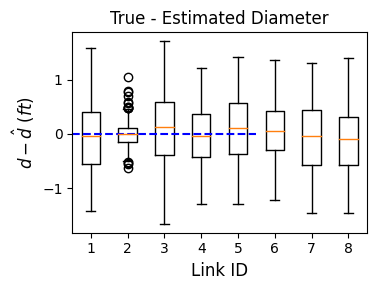

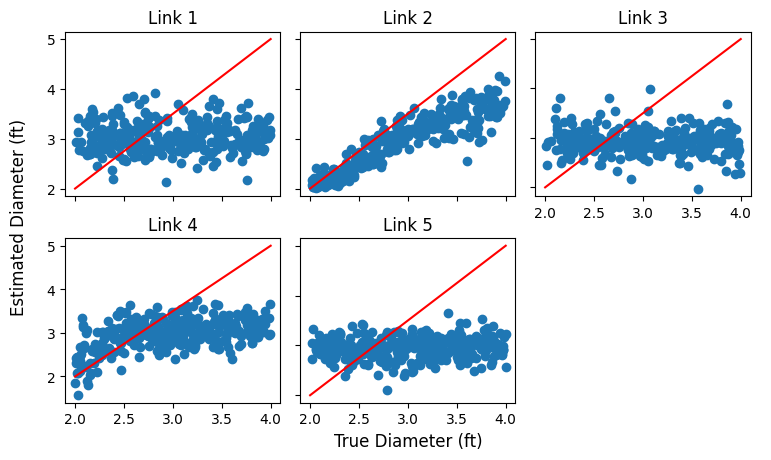

In [6]:
denorm_labels = test_label_all * (4 - 2) + 2
denorm_outputs = test_output_all * (4 - 2) + 2
diff = denorm_labels - denorm_outputs

print(diff.shape)

fig, ax = plt.subplots(figsize=(4,3))
ax.boxplot(diff)
ax.plot([0.5, 5.5], [0, 0], 'b--')
ax.set_xlabel('Link ID', fontsize=12)
ax.set_ylabel('$d - \hat d \ (ft)$', fontsize=12)
ax.set_title('True - Estimated Diameter')
fig.tight_layout()

# fig.savefig(r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Canandaigua\Output\Figures\ann_test_boxplot_all.png", dpi=300)
x1t1 = [2, 4]
y1t1 = [2, 5]

fig, ax = plt.subplots(2,3, figsize=(8,5))

ax[0,0].scatter(denorm_labels[:,0], denorm_outputs[:,0])
ax[0,0].plot(x1t1, y1t1, color='red')
ax[0,0].set_xticklabels([])
ax[0,0].set_title('Link 1')

ax[0,1].scatter(denorm_labels[:,1], denorm_outputs[:,1])
ax[0,1].plot(x1t1, y1t1, color='red')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,1].set_title('Link 2')

ax[0,2].scatter(denorm_labels[:,2], denorm_outputs[:,2])
ax[0,2].plot(x1t1, y1t1, color='red')
ax[0,2].set_yticklabels([])
# ax[0,2].set_xticklabels([])
ax[0,2].set_title('Link 3')

ax[1,0].scatter(denorm_labels[:,3], denorm_outputs[:,3])
ax[1,0].plot(x1t1, y1t1, color='red')
# ax[1,0].set_yticklabels([])
ax[1,0].set_title('Link 4')

ax[1,1].scatter(denorm_labels[:,4], denorm_outputs[:,4])
ax[1,1].plot(x1t1, y1t1, color='red')
ax[1,1].set_yticklabels([])
ax[1,1].set_title('Link 5')

# Delete last plot.
fig.delaxes(ax[1,2])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("True Diameter (ft)", fontsize=12)
plt.ylabel("Estimated Diameter (ft)", fontsize=12)

fig.tight_layout()

# fig.savefig(r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Canandaigua\Output\Figures\ann_test_diams_all.png", dpi=300)

-0.038275562
0.34297222


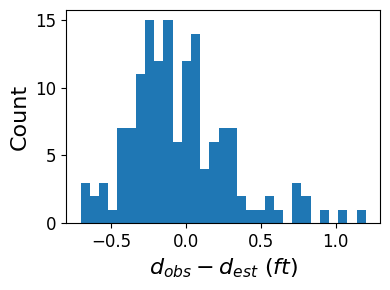

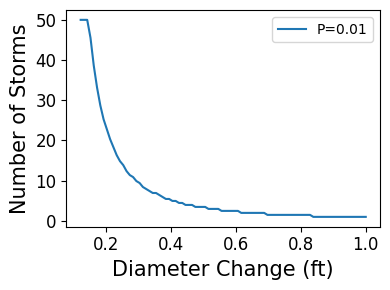

In [13]:
# Histograms around true values.
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.hist(diff[:,1], bins=31)
ax.set_xlabel('$d_{obs} - d_{est} \ (ft)$', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.tick_params(labelsize=12)
fig.tight_layout()
fig.savefig(r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Canandaigua\Output\Figures\sens17_link2_diff_hist.png", dpi=300)

# Compute mean and standard deviation of test data.
d1_mean = np.mean(diff[:,1])
d1_std = np.std(diff[:,1])
print(d1_mean)
print(d1_std)

# T stat significance for varying diameter difference and number of storms.
n1 = diff.shape[0]
del_d = np.linspace(0,1,100)
n2 = np.linspace(1,50,100)
P = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        t_val = del_d[i] / np.sqrt((d1_std**2 / n1) + (d1_std**2 / n2[j]))
        df = n1 + n2[j] - 1
        P[i,j] = scipy.stats.t.sf(t_val, df=df)*2

# Find delta d and n2 that produce a P-value of 0.05.
P_diff = np.abs(P - 0.01)
P_diff_min_idx = np.argmin(P_diff, axis=1)
n_storm = n2[P_diff_min_idx]

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(del_d[12:], n_storm[12:], label='P=0.01')
ax.set_xlabel('Diameter Change (ft)', fontsize=15)
ax.set_ylabel('Number of Storms', fontsize=15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend()
fig.tight_layout()
fig.savefig(r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\Canandaigua\Output\Figures\sens17_P0.01_link2.png", dpi=300)

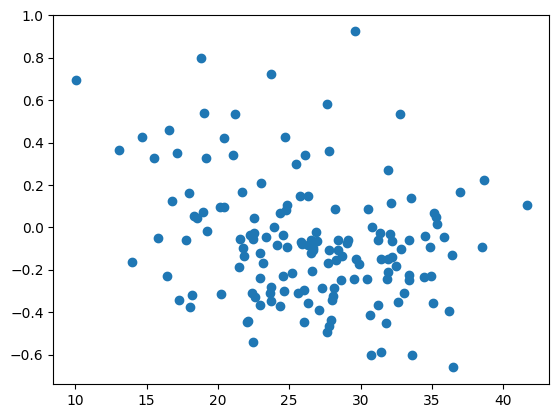

In [15]:
# Prediction accuracy as a function of cumulative precipitation.

# Compute cumulative precipiation.
input_prcp = test_input_all[:,:96] # Precipitation is the first 96 columns.
input_prcp = input_prcp * 2 # Denorm precip.
input_cumu_prcp = np.sum(input_prcp, axis=1)

fig, ax = plt.subplots()
ax.scatter(input_cumu_prcp, diff[:,1])